This notebook is for S4 architecture building

# Settings

In [ ]:
! pip install einops

In [1]:
import os
import os.path as op

# Settings
# Presets from S4 example
n_layers=4
d_model=128 # Model dimension
dropout=0.1
prenorm=True
batch_size=64
num_workers=4

d_input = 1 # Because input is grayscale image. Make 3 for RGB
d_output = 10

# Use to load from a checkpoint
start_epoch = 0

fs = 16000

lr = 1e-2
weight_decay = 1e-2
epochs=100

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Specify the directory you want the datasets to be contained in
pdir="/Users/noahmarkowitz/Documents/GitHub/EC523-SER"
dataset_dir = op.join(pdir,"datasets")



# Test DataLoader

In [2]:
from torch.utils.data import DataLoader
from dataset import download_datasets, SpeechEmotionDataset, get_dataset_info

import torchaudio.transforms as t
from tqdm.auto import tqdm

# Download a single dataset
#download_datasets(dataset_dir)

# Download the rest of the datasets available
#download_datasets(dataset_dir)

# Acquire info on datasets (those that have functions to get data for)
df = get_dataset_info(dataset_dir)

# Make into a Dataset object that a pytorch optimizer can use
# Can optionally specify a sampling rate for all audio files to be in
transforms = t.Spectrogram(n_fft=400)
trainset = SpeechEmotionDataset(df, fs=16000, transform=transforms)

In [3]:
# Check it works
dataiter = iter(trainset)
data, label = next(dataiter)
label

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=torch.uint8)

/var/folders/rs/p4pk0t6n79ngxmbf15cw7qqr0000gn/T/ipykernel_5552/3924606560.py:2: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=201).
  plt.specgram(data.numpy())


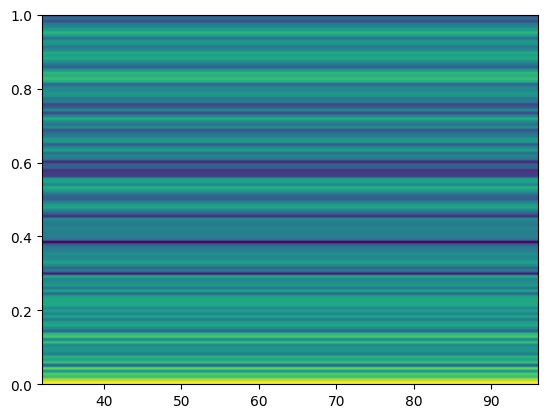

In [3]:
import matplotlib.pyplot as plt
plt.specgram(data.numpy())
plt.show()

In [4]:
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4)


# Get dataset as pandas dataframe and filter

In [ ]:
# Acquire info on datasets (those that have functions to get data for)
df = get_dataset_info(dataset_dir)
#df = df[ df["language"]!="persian",:]
df = df.drop(df[df.language=="persian"].index)
df

# Create DataLoaders for train, test, eval

In [ ]:
def split_train_val(train, val_split):
    train_len = int(len(train) * (1.0-val_split))
    train, val = torch.utils.data.random_split(
        train,
        (train_len, len(train) - train_len),
        generator=torch.Generator().manual_seed(42),
    )
    return train, val


# Specify transforms to use
transforms = t.Spectrogram(n_fft=400)

# Make trainset
trainset = SpeechEmotionDataset(df, fs=fs, transform=transforms)
trainset, _ = split_train_val(trainset, val_split=0.1)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Make valset
valset = SpeechEmotionDataset(df, fs=fs, transform=transforms)
_, valset = split_train_val(valset, val_split=0.1)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Make testset
testset = SpeechEmotionDataset(df, fs=fs, transform=transforms)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Create S4 model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from s4.models.s4.s4d import S4D


# Dropout broke in PyTorch 1.11
if tuple(map(int, torch.__version__.split('.')[:2])) == (1, 11):
    print("WARNING: Dropout is bugged in PyTorch 1.11. Results may be worse.")
    dropout_fn = nn.Dropout
if tuple(map(int, torch.__version__.split('.')[:2])) >= (1, 12):
    dropout_fn = nn.Dropout1d
else:
    dropout_fn = nn.Dropout2d
    

class S4Model(nn.Module):

    def __init__(
        self,
        d_input,
        d_output=10,
        d_model=256,
        n_layers=4,
        dropout=0.2,
        prenorm=False,
        lr=1-2
    ):
        super().__init__()

        self.prenorm = prenorm

        # Linear encoder (d_input = 1 for grayscale and 3 for RGB)
        self.encoder = nn.Linear(d_input, d_model)

        # Stack S4 layers as residual blocks
        self.s4_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(n_layers):
            self.s4_layers.append(
                S4D(d_model, dropout=dropout, transposed=True, lr=min(0.001, lr))
            )
            self.norms.append(nn.LayerNorm(d_model))
            self.dropouts.append(dropout_fn(dropout))

        # Linear decoder
        self.decoder = nn.Linear(d_model, d_output)

    def forward(self, x):
        """
        Input x is shape (B, L, d_input)
        """
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)

        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        for layer, norm, dropout in zip(self.s4_layers, self.norms, self.dropouts):
            # Each iteration of this loop will map (B, d_model, L) -> (B, d_model, L)

            z = x
            if self.prenorm:
                # Prenorm
                z = norm(z.transpose(-1, -2)).transpose(-1, -2)

            # Apply S4 block: we ignore the state input and output
            z, _ = layer(z)

            # Dropout on the output of the S4 block
            z = dropout(z)

            # Residual connection
            x = z + x

            if not self.prenorm:
                # Postnorm
                x = norm(x.transpose(-1, -2)).transpose(-1, -2)

        x = x.transpose(-1, -2)

        # Pooling: average pooling over the sequence length
        x = x.mean(dim=1)

        # Decode the outputs
        x = self.decoder(x)  # (B, d_model) -> (B, d_output)

        return x


In [ ]:
# Model
print('==> Building model..')
model = S4Model(
    d_input=d_input,
    d_output=d_output,
    d_model=d_model,
    n_layers=n_layers,
    dropout=dropout,
    prenorm=prenorm,
    lr=lr
)

model = model.to(device)
if device == 'cuda':
    cudnn.benchmark = True

# Setup Optimizer and Loss function

In [ ]:
def setup_optimizer(model, lr, weight_decay, epochs):
    """
    S4 requires a specific optimizer setup.

    The S4 layer (A, B, C, dt) parameters typically
    require a smaller learning rate (typically 0.001), with no weight decay.

    The rest of the model can be trained with a higher learning rate (e.g. 0.004, 0.01)
    and weight decay (if desired).
    """

    # All parameters in the model
    all_parameters = list(model.parameters())

    # General parameters don't contain the special _optim key
    params = [p for p in all_parameters if not hasattr(p, "_optim")]

    # Create an optimizer with the general parameters
    optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)

    # Add parameters with special hyperparameters
    hps = [getattr(p, "_optim") for p in all_parameters if hasattr(p, "_optim")]
    hps = [
        dict(s) for s in sorted(list(dict.fromkeys(frozenset(hp.items()) for hp in hps)))
    ]  # Unique dicts
    for hp in hps:
        params = [p for p in all_parameters if getattr(p, "_optim", None) == hp]
        optimizer.add_param_group(
            {"params": params, **hp}
        )

    # Create a lr scheduler
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    # Print optimizer info
    keys = sorted(set([k for hp in hps for k in hp.keys()]))
    for i, g in enumerate(optimizer.param_groups):
        group_hps = {k: g.get(k, None) for k in keys}
        print(' | '.join([
            f"Optimizer group {i}",
            f"{len(g['params'])} tensors",
        ] + [f"{k} {v}" for k, v in group_hps.items()]))

    return optimizer, scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer, scheduler = setup_optimizer(
    model, lr=lr, weight_decay=weight_decay, epochs=epochs
)

# Set train() function

In [ ]:
def train():
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for batch_idx, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        pbar.set_description(
            'Batch Idx: (%d/%d) | Loss: %.3f | Acc: %.3f%% (%d/%d)' %
            (batch_idx, len(trainloader), train_loss/(batch_idx+1), 100.*correct/total, correct, total)
        )

# Set eval() function

In [ ]:
def eval(epoch, dataloader, checkpoint=False):
    global best_acc
    model.eval()
    eval_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(dataloader))
        for batch_idx, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            eval_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            pbar.set_description(
                'Batch Idx: (%d/%d) | Loss: %.3f | Acc: %.3f%% (%d/%d)' %
                (batch_idx, len(dataloader), eval_loss/(batch_idx+1), 100.*correct/total, correct, total)
            )

    # Save checkpoint.
    if checkpoint:
        acc = 100.*correct/total
        if acc > best_acc:
            state = {
                'model': model.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')
            best_acc = acc

        return acc

# Run training and evaluation

In [ ]:
pbar = tqdm(range(start_epoch, epochs))
for epoch in pbar:
    if epoch == 0:
        pbar.set_description('Epoch: %d' % (epoch))
    else:
        pbar.set_description('Epoch: %d | Val acc: %1.3f' % (epoch, val_acc))
    train()
    val_acc = eval(epoch, valloader, checkpoint=True)
    eval(epoch, testloader)
    scheduler.step()